In [31]:
import pyemu
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import sys
sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

In [2]:
t_d ="master_glm"
case = "3D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cond,cond,log,6,-3 to -2,-2,-3,0.25
irr__multiplier,irr__multiplier,log,14,0,0.30103,-0.09691,0.099485
kp_pc_inst:0,kp_pc_inst:0,log,110,-3 to 0.60206,0.60206,-3,0.900515
kp_q_inst:0,kp_q_inst:0,log,83,-2.30103 to 0.477121,0.477121,-2.30103,0.694538


[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

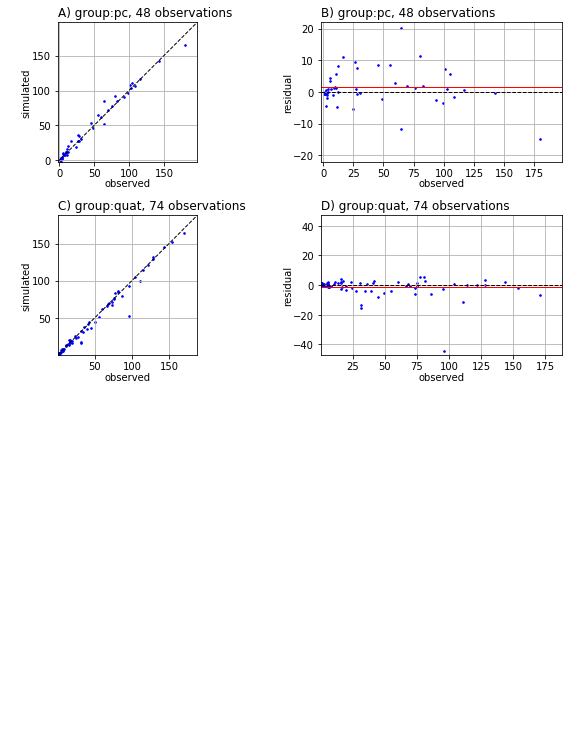

In [3]:
pst.plot(kind='1to1')

In [4]:
pst.control_data.noptmax = 6 # number of iterations (should be set to a great value (50))
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:6, npar_adj:213, nnz_obs:122


In [8]:
# DO the inversion
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=8,worker_root=".",
                             master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

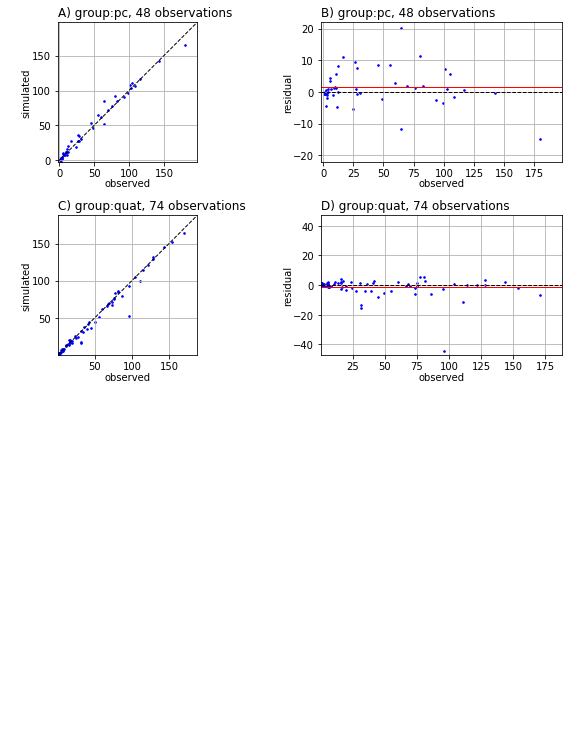

In [7]:
m_d = "master_glm_run"
pst_2 = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_2.plot(kind="1to1")

4672.957681119637 {'pc': 1659.207993676614, 'quat': 3013.7496874430226} {'pc': 0.35506591475895183, 'quat': 0.6449340852410482}


[None,
 None,

<Figure size 576x756 with 0 Axes>

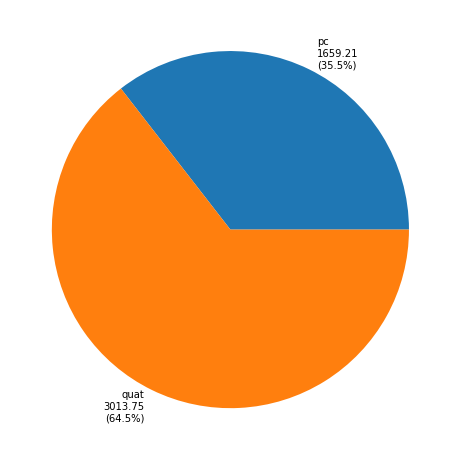

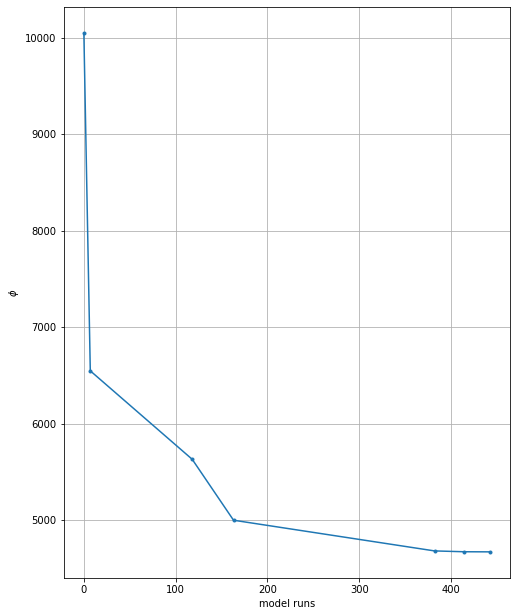

In [5]:
pst_2.plot()

C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


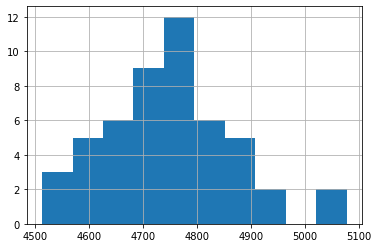

In [6]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

ax = oe.phi_vector.hist()

(array([39.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  3., 66.]),
 array([-3.      , -2.639794, -2.279588, -1.919382, -1.559176, -1.19897 ,
        -0.838764, -0.478558, -0.118352,  0.241854,  0.60206 ]),
 <a list of 10 Patch objects>)

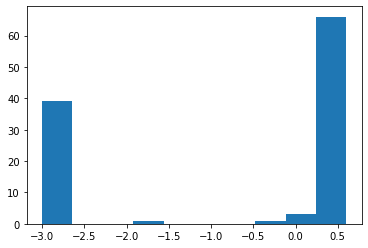

In [90]:
idx_kpq = [i for i in range(dfp.shape[0]) if "KP_PC" in dfp.index[i]]
plt.hist(dfp.reset_index().loc[idx_kpq]["post_mean"])

(array([24.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1., 54.]),
 array([-2.30103  , -2.0232149, -1.7453998, -1.4675847, -1.1897696,
        -0.9119545, -0.6341394, -0.3563243, -0.0785092,  0.1993059,
         0.477121 ]),
 <a list of 10 Patch objects>)

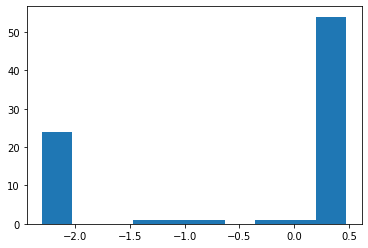

In [10]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
dfp["post_mean"]

name
KP_Q_INST:0_I:15_J:135            -0.046186
KP_Q_INST:0_I:25_J:135            -0.194496
KP_Q_INST:0_I:35_J:125             0.477121
KP_Q_INST:0_I:35_J:135             0.477121
KP_Q_INST:0_I:45_J:105            -2.301030
                                     ...   
MULTIPLIER_IRR_INST:0_ZONE:14.0    0.000000
MULTIPLIER_IRR_INST:0_ZONE:9.0     0.000000
MULTIPLIER_IRR_INST:0_ZONE:5.0     0.000000
MULTIPLIER_IRR_INST:0_ZONE:11.0    0.000000
MULTIPLIER_IRR_INST:0_ZONE:6.0     0.000000
Name: post_mean, Length: 213, dtype: float64

In [11]:
pst_2.parameter_data.parval1 = 10**dfp["post_mean"].values
pst_2.control_data.noptmax = 0 # one run

pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)

noptmax:0, npar_adj:213, nnz_obs:122


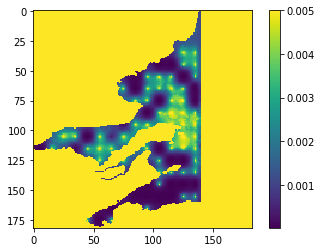

In [12]:
# inversion
plt.imshow(np.loadtxt(os.path.join(t_d,"kq.txt")))
plt.colorbar()

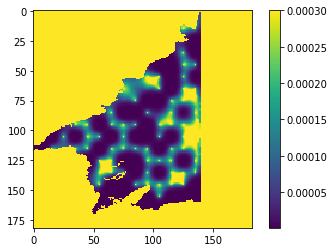

In [96]:
# inversion
plt.imshow(np.loadtxt(os.path.join(t_d,"kpc.txt")))
plt.colorbar()

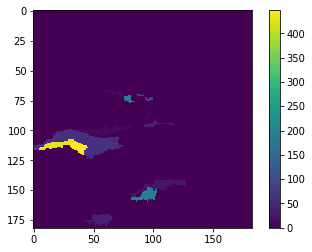

In [14]:
plt.imshow((np.loadtxt(os.path.join(t_d,"irr.txt"))))
plt.colorbar()

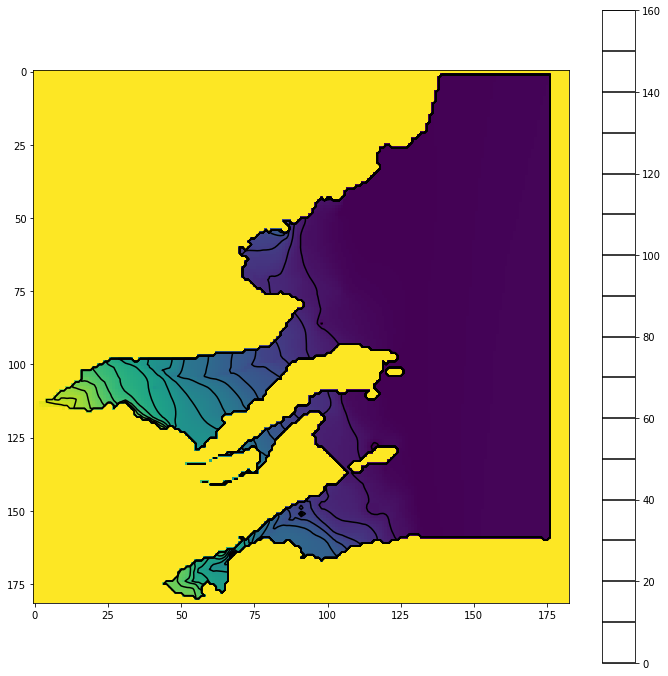

In [97]:
fig,ax = plt.subplots(figsize=(12,12))

layer = 1

head = get_heads("PEST_3D_R","master_glm")
plt.imshow(head[layer],vmin=0,vmax=170)
plt.contour(head[layer],colors="k",levels=np.arange(0,170,10))
plt.colorbar()

In [32]:
top,botm,idomain,delr,delc = read_pickle(os.path.join("workspace","export_dis3D"))

In [33]:
#control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
grid = fp.discretization.StructuredGrid(delc,delr,xoff =664525 ,yoff =6152875 )
nlay=5
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [38]:
nrow=idomain.shape[0]
ncol=idomain.shape[1]

Misfit : 3.296735748776577 m 
MSE    : 38.30293016700171
φ      : 4672.957480374209


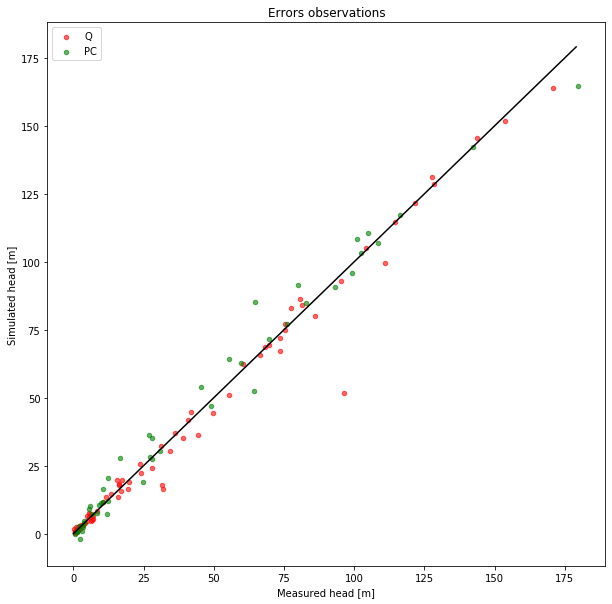

In [58]:
color = ["y","red","blue","green","black"]
label = ["sea","Q","inter","PC","PMS"]
fig = plt.figure(figsize=(10,10))

for ilay in [1,3]:
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

# stats
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head_2 = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head_2[Control_pz!=0]))
MSE = np.nanmean((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
phi = np.nansum((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
print("Misfit : {} m ".format(np.nanmean(Misfit)))
print("MSE    : {}".format(MSE))
print("\u03C6      : {}".format(phi))